## ENV SETUP

1. Install uv (or do it you're own way)
2. Run `uv sync`
3. Run `source .venv/bin/activate`

You're good to go.

# Instructions

The Task : Create the best CadQuery code generator model. 

1. Load the dataset (147K pairs of Images/CadQuery code).
2. Create a baseline model and evaluate it with the given metrics.
3. Enhance by any manner the baseline model and evaluate it again.
4. Explain you choices and possible bottlenecks. 
5. Show what enhancements you would have done if you had more time.

You can do *WHATEVER* you want, be creative, result is not what matters the most. 
Creating new model architectures, reusing ones you used in the past, fine-tuning, etc...

If you are GPU poor, there are solutions. Absolute value is not what matters, relative value between baseline and enhanced model is what matters.

In [21]:
from datasets import load_dataset
ds = load_dataset("CADCODER/GenCAD-Code", num_proc=16, split=["train", "test"], cache_dir="./hf_cache")

In [22]:
print(ds)


[Dataset({
    features: ['image', 'deepcad_id', 'cadquery', 'token_count', 'prompt', 'hundred_subset'],
    num_rows: 147289
}), Dataset({
    features: ['image', 'deepcad_id', 'cadquery', 'token_count', 'prompt', 'hundred_subset'],
    num_rows: 7355
})]


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x448 at 0x78ED4B782F80>, 'deepcad_id': '0000/00006371', 'cadquery': 'import cadquery as cq\n# Generating a workplane for sketch 0\nwp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.015625, -0.0078125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))\nloop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0007948582418457166, -0.0019189575476279677), (0.0027138157894736844, -0.0027138157894736844)).lineTo(0.021217105263157895, -0.0027138157894736844).threePointArc((0.022787161438489866, -0.00206347722796355), (0.0234375, -0.000493421052631579)).lineTo(0.0234375, 0.018256578947368422).threePointArc((0.02283825686147997, 0.019949990385858287), (0.021217105263157895, 0.020723684210526318)).lineTo(0.0022203947368421052, 0.020723684210526318).threePointArc((0.0005992431385200307, 0.019949990385858287), (0.0, 0.018256578947368422)).lineTo(0.0, 0.0).close()\nsolid0=wp_sketch0.add(loop0).extrude(0.75)\nsolid=solid0\n', 'token

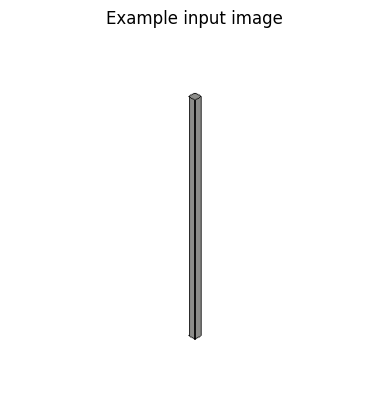

In [23]:
train_ds, test_ds = ds

print(train_ds[0])  

import matplotlib.pyplot as plt

plt.imshow(train_ds[0]['image'])
plt.axis('off')
plt.title("Example input image")
plt.show()

In [38]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "gpt2"
)
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

#  padding
tokenizer.pad_token = tokenizer.eos_token
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

In [68]:
class CADCADDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        pixel_values = feature_extractor(images=item["image"], return_tensors="pt").pixel_values.squeeze()
        labels = tokenizer(item["cadquery"], padding="max_length", truncation=True, max_length=128, return_tensors="pt").input_ids.squeeze()
        return {
            "pixel_values": pixel_values,
            "labels": labels,
        }


train_prepared = CADCADDataset(train_ds)

In [53]:
train_prepared = CADCADDataset(train_ds)

In [76]:
test_prepared = CADCADDataset(test_ds)

In [69]:
import torch

def data_collator(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return {
        "pixel_values": pixel_values,
        "labels": labels,
    }

In [70]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./vit-gpt2-genCAD",
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none"
)

# 

In [71]:
print(train_ds[0])

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=448x448 at 0x78ED4BF97A30>, 'deepcad_id': '0000/00006371', 'cadquery': 'import cadquery as cq\n# Generating a workplane for sketch 0\nwp_sketch0 = cq.Workplane(cq.Plane(cq.Vector(-0.015625, -0.0078125, 0.0), cq.Vector(1.0, 0.0, 0.0), cq.Vector(0.0, 0.0, 1.0)))\nloop0=wp_sketch0.moveTo(0.0, 0.0).threePointArc((0.0007948582418457166, -0.0019189575476279677), (0.0027138157894736844, -0.0027138157894736844)).lineTo(0.021217105263157895, -0.0027138157894736844).threePointArc((0.022787161438489866, -0.00206347722796355), (0.0234375, -0.000493421052631579)).lineTo(0.0234375, 0.018256578947368422).threePointArc((0.02283825686147997, 0.019949990385858287), (0.021217105263157895, 0.020723684210526318)).lineTo(0.0022203947368421052, 0.020723684210526318).threePointArc((0.0005992431385200307, 0.019949990385858287), (0.0, 0.018256578947368422)).lineTo(0.0, 0.0).close()\nsolid0=wp_sketch0.add(loop0).extrude(0.75)\nsolid=solid0\n', 'token

## Evaluation Metrics

In [72]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./vit-gpt2-genCAD",
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    report_to="none"
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_prepared,
    data_collator=data_collator,
    tokenizer=tokenizer  
)
trainer.train()

/tmp/ipykernel_549626/2926231735.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


KeyboardInterrupt: 

In [77]:
trainer.evaluate(eval_dataset=test_prepared)

{'eval_loss': 0.152730330824852}

In [81]:
trainer.save_model("vit-gpt2-genCAD-checkpoint")

## Evaluation Metrics

1. Valid Syntax Rate metric assess the validity of the code by executing and checking if error are returned.
2. Best IOU assess the similarity between the meshes generated by the code.

In [82]:
from metrics.valid_syntax_rate import evaluate_syntax_rate_simple
from metrics.best_iou import get_iou_best

In [85]:
model.eval()
predictions = {}
nb_samples = 10

for i in range(nb_samples):
    item = test_prepared[i]
    inputs = {"pixel_values": item["pixel_values"].unsqueeze(0).to(model.device)}
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_length=512)
    predictions[f"sample_{i}"] = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# VSR
vsr = evaluate_syntax_rate_simple(predictions)
print(" Valid Syntax Rate:", vsr)

# IOU
ious = []
for i in range(nb_samples):
    true_code = test_ds[i]["cadquery"]
    pred_code = predictions[f"sample_{i}"]
    try:
        iou = get_iou_best(true_code, pred_code)
        ious.append(iou)
    except Exception as e:
        print(f"Erreur pour sample_{i}:", e)

avg_iou = sum(ious) / len(ious) if ious else 0.0
print(" Average Best IOU:", avg_iou)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set.

 Valid Syntax Rate: 0.0
Erreur pour sample_0: Error executing script unknown: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 3)
Erreur pour sample_1: Error executing script unknown: invalid syntax (<string>, line 1)
Erreur pour sample_2: Error executing script unknown: unmatched ')' (<string>, line 3)
Erreur pour sample_3: Error executing script unknown: invalid syntax (<string>, line 1)
Erreur pour sample_4: Error executing script unknown: invalid syntax (<string>, line 1)
Erreur pour sample_5: Error executing script unknown: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 53)
Erreur pour sample_6: Error executing script unknown: unmatched ')' (<string>, line 3)
Erreur pour sample_7: Error executing script unknown: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 3)
Erreur pour sample_8: Error

## Résumé de l’approche!
J’ai suivi les étapes proposées dans le notebook :

- Chargement du dataset GenCAD-Code.
- Création d’un modèle baseline basé sur ViT (Vision Transformer) pour l’encodeur et GPT-2 pour le décodeur, via `VisionEncoderDecoderModel`.
- Préparation des données avec une classe personnalisée `CADCADDataset` afin de transformer chaque paire image/code en entrée modèle.
- Lancement de l'entraînement à l’aide de `Seq2SeqTrainer`.

J'ai interrompu L’entraînement très tôt, à seulement **[0.17 / 3] epochs**, par manque de temps.

## Résultats d’évaluation

- **Valid Syntax Rate** : 0.0 — les scripts générés contenaient des erreurs de syntaxe, souvent dès les premières lignes (zéros non autorisés, parenthèses non fermées…).
- **Best IOU** : 0.0 — en lien direct avec l’échec d’exécution du code généré.
    
## Limites et pistes d’amélioration

Si j’avais eu plus de temps :

- Terminer l’entraînement complet afin d’obtenir des sorties plus cohérentes.
- Ajouter un set de validation et analyser l’évolution des performances.
- Intégrer un post-traitement simple pour corriger certaines erreurs syntaxiques avant exécution.
- Tester d'autres variantes de modèles comme GPT-Neo ou un ViT de taille plus grande pour améliorer la génération.

In [3]:
## Example usage of the metrics
sample_code = """
height = 60.0
width = 80.0
thickness = 10.0
diameter = 22.0

# make the base
result = (
    cq.Workplane("XY")
    .box(height, width, thickness)
)
"""

sample_code_2 = """
 height = 60.0
 width = 80.0
 thickness = 10.0
 diameter = 22.0
 padding = 12.0

 # make the base
 result = (
     cq.Workplane("XY")
     .box(height, width, thickness)
     .faces(">Z")
     .workplane()
     .hole(diameter)
     .faces(">Z")
     .workplane()
     .rect(height - padding, width - padding, forConstruction=True)
     .vertices()
     .cboreHole(2.4, 4.4, 2.1)
 )
"""
codes = {
    "sample_code": sample_code,
    "sample_code_2": sample_code_2,
}
vsr = evaluate_syntax_rate_simple(codes)
print("Valid Syntax Rate:", vsr)
iou = get_iou_best(sample_code, sample_code_2)
print("IOU:", iou)

Valid Syntax Rate: 1.0
IOU: 0.5834943417057687


## Have Fun